## Ejercicio 4

In [4]:
from qiskit import IBMQ

provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-03-04 12:59:33,420: Credentials are already in use. The existing account in the session will be replaced.


### Qiskit - Teleportación

Primero definimos el circuito del ejercicio 1, pero esta vez con qiskit.

In [5]:
from qiskit import QuantumCircuit

qiskit_tp = QuantumCircuit(3, 1)

qiskit_tp.h(1)
qiskit_tp.cx(1, 2)
qiskit_tp.cx(0, 1)
qiskit_tp.h(0)
qiskit_tp.cx(1, 2)
qiskit_tp.cz(0, 2)
qiskit_tp.measure(2, 0)

qiskit_tp.draw()

┌───┐      
q_0: ────────────■──┤ H ├─■────
     ┌───┐     ┌─┴─┐└───┘ │    
q_1: ┤ H ├──■──┤ X ├──■───┼────
     └───┘┌─┴─┐└───┘┌─┴─┐ │ ┌─┐
q_2: ─────┤ X ├─────┤ X ├─■─┤M├
          └───┘     └───┘   └╥┘
c: 1/════════════════════════╩═
                             0

Probamos en el circuito en un simulador antes de subirlo a un bakcend real.

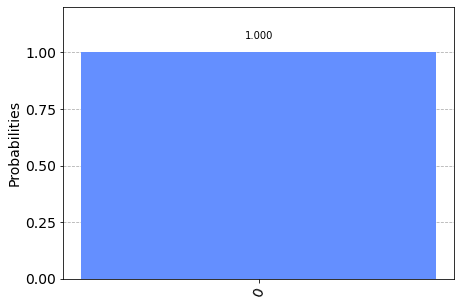

In [6]:
from qiskit import Aer
from qiskit.visualization import plot_histogram

sim = Aer.get_backend("qasm_simulator")
counts = sim.run(qiskit_tp, shots=1000).result().get_counts()
plot_histogram(counts)


El resultado es el esperado.

Además, si usamos el *statevector_simulator* junto con las visualizaciones que nos aporta qiskit, podemos ver el resultado de una forma mucho más gráfica.

Esto no se puede hacer en computadores reales, ya que no podemos inicializar un qubit a un valor determinado, ni conocer el estado de un qubit sin medirlo y colapsarlo

Primero obtenemos un estado aleatorio, que se usará para inicializar q0.

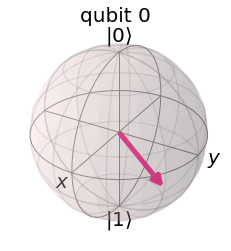

In [45]:
from qiskit.quantum_info import random_statevector
from qiskit.visualization import plot_bloch_multivector


random_state = random_statevector(2)
plot_bloch_multivector(random_state)

Definimos el circuito de antes, pero le agregamos la operación de inicialización a q0.

In [47]:
from qiskit.extensions import Initialize

circuit_sv = QuantumCircuit(3)

circuit_sv.append(Initialize(random_state), [0])
circuit_sv.h(1)
circuit_sv.cx(1, 2)
circuit_sv.cx(0, 1)
circuit_sv.h(0)
circuit_sv.cx(1, 2)
circuit_sv.cz(0, 2)

circuit_sv.draw()

┌────────────────────────────────────────────────┐          ┌───┐   
q_0: ┤ Initialize(-0.39193+0.48677j,-0.7703-0.12683j) ├───────■──┤ H ├─■─
     └─────────────────────┬───┬──────────────────────┘     ┌─┴─┐└───┘ │ 
q_1: ──────────────────────┤ H ├─────────────────────────■──┤ X ├──■───┼─
                           └───┘                       ┌─┴─┐└───┘┌─┴─┐ │ 
q_2: ──────────────────────────────────────────────────┤ X ├─────┤ X ├─■─
                                                       └───┘     └───┘

Ejectuamos el circuito anterior en el simulador.

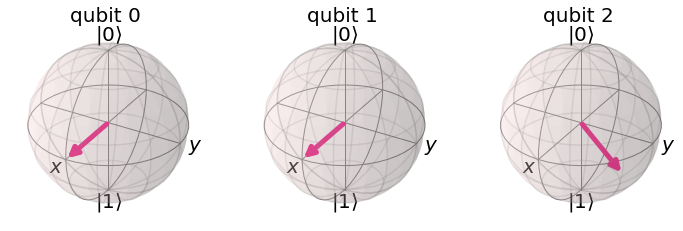

In [48]:
from qiskit import Aer

sv_sim = Aer.get_backend('statevector_simulator')
result = sv_sim.run(circuit_sv).result().get_statevector()

plot_bloch_multivector(result)

Podemos observar que, al final, los estados de q0 y q1 son aleatorios, pero q2 siempre se encuentra en el mismo estado mismo que q0 al principio. 

Esto se corresponde con las mediciones de las simulaciones anteriores, en los que observabamos que siempre se medían estados en los que q2 tenía el valor correcto.

Ahora vamos a ejecutar el codigo en un backend real de IBM.

Esta vez se va a escoger el backend menos ocupado.


In [67]:
from qiskit.providers.ibmq import least_busy

backend = least_busy(provider.backends(filters=lambda x:  x.configuration().n_qubits == 5))
print(backend)

ibmq_belem


Transpilamos y encolamos el circuito en el backend. (*ibmq_belem*)

In [7]:
from qiskit import transpile
backend = provider.get_backend("ibmq_belem")
circuit = transpile(qiskit_tp, backend)

job = backend.run(circuit)
print("Job ID:", job.job_id())

Job ID: 622200e62f0e17970b824f41


Se recoge el resultado.

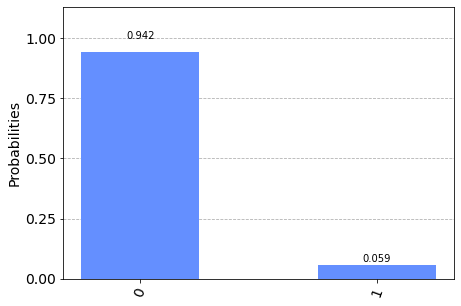

In [11]:
from qiskit.visualization import plot_histogram

backend = provider.get_backend("ibmq_belem")

result = backend.retrieve_job('622200e62f0e17970b824f41').result()
plot_histogram(result.get_counts())

Los resultados son correctos. El nivel de ruido bastante bajo, ya que hemos obtenido un resultado correcto un 94.2% de las veces.

### Qiskit - Codificación superdensa.

Definimos el circuito para la codificación superdensa usando Qiskit. (Vamos a enviar el estado *10*)

In [9]:
from qiskit import QuantumCircuit

qiskit_sd = QuantumCircuit(2, 2)
qiskit_sd.h(1)
qiskit_sd.cx(1, 0)
qiskit_sd.z(1)
qiskit_sd.cx(1, 0)
qiskit_sd.h(1)

qiskit_sd.measure([0, 1], [0, 1])

qiskit_sd.draw()

┌───┐     ┌───┐     ┌─┐   
q_0: ─────┤ X ├─────┤ X ├─────┤M├───
     ┌───┐└─┬─┘┌───┐└─┬─┘┌───┐└╥┘┌─┐
q_1: ┤ H ├──■──┤ Z ├──■──┤ H ├─╫─┤M├
     └───┘     └───┘     └───┘ ║ └╥┘
c: 2/══════════════════════════╩══╩═
                               0  1

Probamos el código en un simulador.

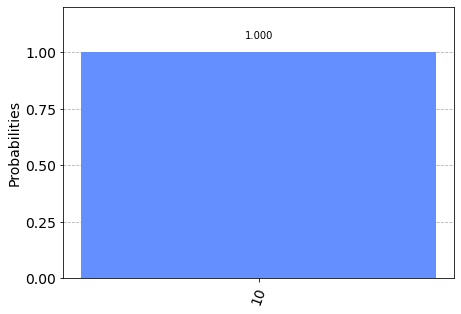

In [10]:
from qiskit import Aer
from qiskit.visualization import plot_histogram

sim = Aer.get_backend("qasm_simulator")

counts = sim.run(qiskit_sd, shots=1000).result().get_counts()
plot_histogram(counts)

El circuito está definido correctamente.

Vamos a transpilarlo y subirlo al backend real (*ibmq_belem*).

In [62]:
from qiskit import transpile

circuit = transpile(qiskit_sd, backend)

job = backend.run(circuit)
print("Job ID:", job.job_id())

Job ID: 6220acf3f5225d91ca64def0


Se recogen los resultados.

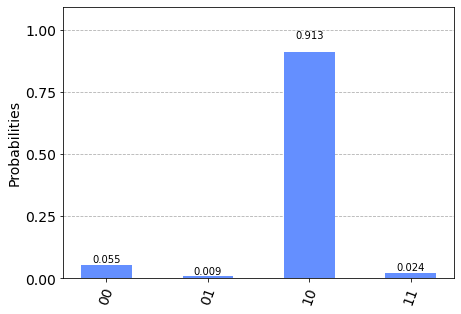

In [3]:
from qiskit.visualization import plot_histogram

backend = provider.get_backend("ibmq_belem")

result = backend.retrieve_job('6220acf3f5225d91ca64def0').result()
plot_histogram(result.get_counts())

### Ionq - Teleportación

Definimos el mismo circuito que en el ejercicio 2.

In [4]:
from braket.circuits import Circuit
    
ionQ_tp = Circuit().h(1).cnot(1, 2).cnot(0, 1).h(0).cnot(1, 2).rz(0, 2)
print(ionQ_tp)

T  : |0|1|2|3|  4  |
                    
q0 : -----C-H-Rz(2)-
          |         
q1 : -H-C-X-C-------
        |   |       
q2 : ---X---X-------

T  : |0|1|2|3|  4  |


Lanzamos la tarea al computador de IonQ.

In [5]:
import boto3
from braket.circuits import Circuit
from braket.aws import AwsDevice

device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
s3_folder = ("amazon-braket-f085dc433a90", "apcc2022/JulianCamara/IONQ")

task = device.run(ionQ_tp, s3_folder)
print("Task:",task.id)
print("Status:", task.state())

Task: arn:aws:braket:us-east-1:975085098040:quantum-task/d6a1b1ef-ee88-4c9f-9fc8-ef0600a37855
Status: CREATED


Esperamos a los resultados y los mostramos.

{'0': 0.963, '1': 0.03700000000000003}


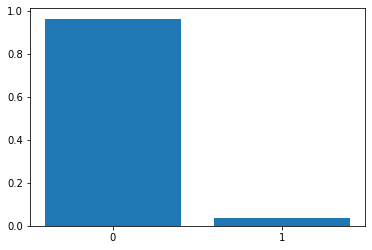

In [1]:
# Se recogen los resultados

from braket.aws import AwsQuantumTask
from matplotlib import pyplot as plt

# restore task with unique arn
task = AwsQuantumTask(arn="arn:aws:braket:us-east-1:975085098040:quantum-task/d6a1b1ef-ee88-4c9f-9fc8-ef0600a37855")
# retrieve the result of the task
estado = task.state()

if task.state() == "QUEUED":
    print("En cola")

else:
    measurements = task.result().measurements

     # Nos quedamos solo con las mediciones de q2.
    ceros = len([x for x in measurements if x[2] == 0]) / 1000
    results = {'0': ceros, 
            '1': 1 - ceros}

    # Se muestran los resultados.
    plt.bar(results.keys(), results.values())
    print(results)

Los resultados son correctos, ya que el algoritmo ha funcionado correctamente, ya que obtenemos un 0 siempre a la salida de q2, que es el valor que tenía inicialmente q0.

Los niveles de ruido son bajos, y obtenemos un resultado esperado el 96.3% de las veces.

### Ionq - Codificación superdensa.

Definimos el circuito utilizado para la codificación superdensa. (Enviamos el estado *01*)

In [11]:
from braket.circuits import Circuit

ionQ_sd = Circuit().h(1).cnot(1, 0).z(1).cnot(1, 0).h(1)
print(ionQ_sd)

T  : |0|1|2|3|4|
                
q0 : ---X---X---
        |   |   
q1 : -H-C-Z-C-H-

T  : |0|1|2|3|4|


Lanzamos la tarea.

In [13]:
import boto3
from braket.circuits import Circuit
from braket.aws import AwsDevice

device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
s3_folder = ("amazon-braket-f085dc433a90", "apcc2022/JulianCamara/IONQ")

task = device.run(ionQ_sd, s3_folder)
print("Task:",task.id)
print("Status:", task.state())

Task: arn:aws:braket:us-east-1:975085098040:quantum-task/b5fc7209-84f6-407c-a862-12066747e7bb
Status: CREATED


Esperamos a los resultados y los mostramos.

Counter({'01': 972, '00': 20, '11': 8})


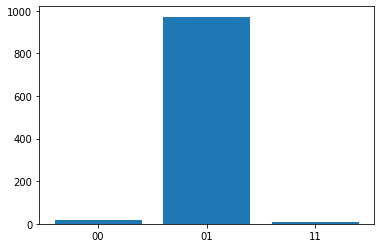

In [3]:
# Se recogen los resultados

from braket.aws import AwsQuantumTask
from matplotlib import pyplot as plt

# restore task with unique arn
task = AwsQuantumTask(arn="arn:aws:braket:us-east-1:975085098040:quantum-task/b5fc7209-84f6-407c-a862-12066747e7bb")
# retrieve the result of the task
estado = task.state()

if task.state() == "QUEUED":
    print("En cola")

else:
    results = task.result().measurement_counts

    # Se muestran los resultados.
    plt.bar(results.keys(), results.values())
    print(results)

Los resultados obtenidos vuelven a ser correctos. En este caso el 97.2% de los resultados medidos son correctos, por lo que el nivel de ruido es bastante bajo.

### Rigetti - Teleportación

En este caso podemos usar el mismo circuito de braket que usamos anteriormente para los computadores de ionQ.

In [34]:
from braket.circuits import Circuit

rigetti_tp = Circuit().h(1).cnot(1, 2).cnot(0, 1).h(0).cnot(1, 2).rz(0, 2)
print(rigetti_tp)

T  : |0|1|2|3|  4  |
                    
q0 : -----C-H-Rz(2)-
          |         
q1 : -H-C-X-C-------
        |   |       
q2 : ---X---X-------

T  : |0|1|2|3|  4  |


Lanzamos el circuito al computador de Rigetti.

In [35]:
import boto3
from braket.circuits import Circuit
from braket.aws import AwsDevice

device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1")
s3_folder = ("amazon-braket-f085dc433a90", "apcc2022/JulianCamara/Rigetti")

task = device.run(rigetti_tp, s3_folder)
print("Task:",task.id)
print("Status:", task.state())

Task: arn:aws:braket:us-west-1:975085098040:quantum-task/627ce834-2274-4cfa-ab68-5a9b46a73698
Status: CREATED


Se recogen los resultados.

{'0': 0.56, '1': 0.43999999999999995}


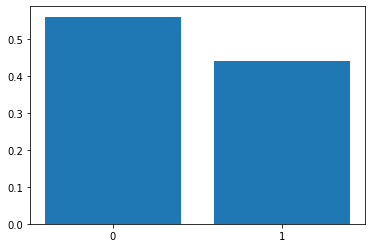

In [27]:
from braket.aws import AwsQuantumTask
from matplotlib import pyplot as plt

# restore task with unique arn
# task = AwsQuantumTask(arn="arn:aws:braket:us-west-1:975085098040:quantum-task/1a9a7b22-3766-4ec5-95c7-094fe4e64f08")
task = AwsQuantumTask(arn="arn:aws:braket:us-west-1:975085098040:quantum-task/627ce834-2274-4cfa-ab68-5a9b46a73698")
# retrieve the result of the task

measurements = task.result().measurements

# Nos quedamos solo con las mediciones de q2.
ceros = len([x for x in measurements if x[2] == 0]) / 1000
results = {'0': ceros, 
        '1': 1 - ceros}

# Se muestran los resultados.
plt.bar(results.keys(), results.values())
print(results)

En este caso el ruido es muy elevado. Las mediciones del resultado correcto soo son un 56% del total.

Vamos a probar con una segunda ejecución.

{'0': 0.579, '1': 0.42100000000000004}


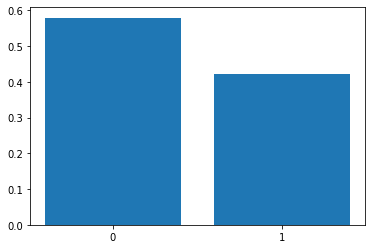

In [28]:
from braket.aws import AwsQuantumTask
from matplotlib import pyplot as plt

# restore task with unique arn
task = AwsQuantumTask(arn="arn:aws:braket:us-west-1:975085098040:quantum-task/463f6a0d-bc0d-4b75-b453-2a50f40bcf6e")
# retrieve the result of the task

measurements = task.result().measurements

# Nos quedamos solo con las mediciones de q2.
ceros = len([x for x in measurements if x[2] == 0]) / 1000
results = {'0': ceros, 
        '1': 1 - ceros}

# Se muestran los resultados.
plt.bar(results.keys(), results.values())
print(results)

De nuevo el ruido vuelve a ser elevado, esta vez un 57.9% de resultados correctos.

### Rigetti - Codificación superdensa

In [29]:
from braket.circuits import Circuit

# Enviamos el estado 01
rigetti_sd = Circuit().h(1).cnot(1, 0).z(1).cnot(1, 0).h(1)
print(rigetti_sd)

T  : |0|1|2|3|4|
                
q0 : ---X---X---
        |   |   
q1 : -H-C-Z-C-H-

T  : |0|1|2|3|4|


In [30]:
import boto3
from braket.circuits import Circuit
from braket.aws import AwsDevice

device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1")
s3_folder = ("amazon-braket-f085dc433a90", "apcc2022/JulianCamara/Rigetti")

task = device.run(rigetti_sd, s3_folder)
print("Task:",task.id)
print("Status:", task.state())

Task: arn:aws:braket:us-west-1:975085098040:quantum-task/9121f76c-d035-4588-afb9-3b5d64653495
Status: CREATED


Counter({'01': 950, '00': 26, '11': 22, '10': 2})


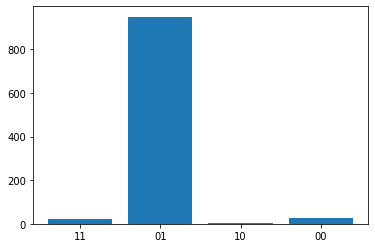

In [33]:
from braket.aws import AwsQuantumTask
from matplotlib import pyplot as plt

# restore task with unique arn
task = AwsQuantumTask(arn="arn:aws:braket:us-west-1:975085098040:quantum-task/9121f76c-d035-4588-afb9-3b5d64653495")
# retrieve the result of the task

results = task.result().measurement_counts

# Se muestran los resultados.
plt.bar(results.keys(), results.values())
print(results)